## **Project Title**: Integrating Retail Demand Forecasting and Inventory Optimization to Enhance Supply Chain Efficiency



## Import Required Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error


from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load Dataset

In [2]:
# Drive Mounting

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check  files in folder

datasets_list = os.listdir('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy')

for files in datasets_list:
  print(files)

sales_train_evaluation.csv
sell_prices.csv
sales_train_validation.csv
calendar.csv
sample_submission.csv
sales_merge_dataset.csv


**Note:**
1. sales_train_validation.csv is the main dataset for time-series modelling which contains daily unit sales for each item–store combination.

2. sell_prices.csv contains historical prices for each item–store which is needed to understand price elasticity

3. calendar.csv contains date-level attributes such as events, SNAP, weekdays, month, year which useful for adding event features, capturing seasonality, understanding demand spikes.

4. Skipping sales_train_evaluation.csv and sample_submission.csv because they are competition-specific files not needed for training, validation, or analysis.

In [ ]:
# Load my required dateset

path = '/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy'


sales = pd.read_csv(os.path.join(path, 'sales_train_validation.csv'))
calendar = pd.read_csv(os.path.join(path, 'calendar.csv'))
prices = pd.read_csv(os.path.join(path, 'sell_prices.csv'))

print("Sales shape:", sales.shape)
print("Calendar shape:", calendar.shape)
print("Prices shape:", prices.shape)

Sales shape: (30490, 1919)
Calendar shape: (1969, 14)
Prices shape: (6841121, 4)


In [ ]:
# Check Sales dataset
sales.head(3)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   

   d_97  d_98  d_99  d_100  d_101  d_102  d_103  d_104  d_105  d_106  d_107  \
0     0     0     0      0      0      0      0      0      0      0      0   
1     0     0     0      0      0      0      0      0      0      0      0   
2     0     0     0      0      0      0      0      0      0      0      0   

   d_108  d_109  d_110  d_111  d_112  d_113  d_114  d_115  d_116  d_117  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   

   d_118  d_119  d_120  d_121  d_122  d_123  d_124  d_125  d_126  d_127  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   

   d_128  d_129  d_130  d_131  d_132  d_133  d_134  d_135  d_136  d_137  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   

   d_138  d_139  

In [ ]:
# Check DataFrame’s structure
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


Insights:
* It’s a wide dataset with mostly numeric daily sales data and a few categorical identifiers.

In [ ]:
# Check Missing Values

missing_data = sales.isnull().sum()
missing_data[missing_data > 0]

Series([], dtype: int64)

Insights:
* There is not missing value in sales dataset

In [ ]:
# Check unique values in column except day column
for col in sales.columns:
  if not col.startswith('d_'):
    print(f"{col}: {sales[col].nunique()}")


id: 30490
item_id: 3049
dept_id: 7
cat_id: 3
store_id: 10
state_id: 3


**Note:**
* It is large dataset,so I will select one store & one product deppartment for my project


In [ ]:
# Check statistical Summary
sales.describe()

d_1           d_2           d_3           d_4           d_5  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       1.070220      1.041292      0.780026      0.833454      0.627944   
std        5.126689      5.365468      3.667454      4.415141      3.379344   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      360.000000    436.000000    207.000000    323.000000    296.000000   

                d_6           d_7           d_8           d_9          d_10  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.958052      0.918662      1.244080      1.073663      0.838701   
std        4.785947      5.059495      6.617729      5.917204      4.206199   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      314.000000    316.000000    370.000000    385.000000    353.000000   

               d_11          d_12          d_13          d_14          d_15  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.756674      0.775927      0.779141      0.867334      1.142440   
std        3.665969      3.697822      3.486595      3.484608      4.636395   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      279.000000    258.000000    163.000000    107.000000    133.000000   

               d_16          d_17          d_18          d_19          d_20  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       1.193178      0.715120      0.789439      0.703280      0.666382   
std        4.662770      2.993414      3.296922      2.811648      2.611911   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      149.000000    122.000000    111.000000     83.000000     95.000000   

               d_21          d_22          d_23          d_24          d_25  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.777993      1.039324      0.960413      0.786028      0.672384   
std        2.985123      3.923110      3.597620      3.084773      2.874189   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      100.000000    132.000000    120.000000    113.000000    158.000000   

               d_26          d_27          d_28          d_29          d_30  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.680781      0.665038      0.738898      0.980912      0.941522   
std        2.727852      2.637849      2.842334      3.714944      3.688771   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000

In [ ]:
# Check for duplicates

print(sales.duplicated().sum())

0


In [ ]:
# Check count the frequency of unique values of state_ID

sales['state_id'].value_counts()

state_id
CA    12196
TX     9147
WI     9147
Name: count, dtype: int64

In [ ]:
# Check count the frequency of unique values of store_id

sales['store_id'].value_counts()

store_id
CA_1    3049
CA_2    3049
CA_3    3049
CA_4    3049
TX_1    3049
TX_2    3049
TX_3    3049
WI_1    3049
WI_2    3049
WI_3    3049
Name: count, dtype: int64

In [ ]:
# Check count the frequency of unique values of cat_id

sales['cat_id'].value_counts()

cat_id
FOODS        14370
HOUSEHOLD    10470
HOBBIES       5650
Name: count, dtype: int64

In [ ]:
# Check count the frequency of unique values of dept_id

sales['dept_id'].value_counts()

dept_id
FOODS_3        8230
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
HOBBIES_1      4160
FOODS_2        3980
FOODS_1        2160
HOBBIES_2      1490
Name: count, dtype: int64

In [ ]:
# Check unique values

print(sales['state_id'].unique())
print(sales['store_id'].unique())
print(sales['cat_id'].unique())

['CA' 'TX' 'WI']
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
['HOBBIES' 'HOUSEHOLD' 'FOODS']


## Creating subset for demonstration

In [ ]:
# Creating dataset with product selling minimum 10 per day(considering day 1)

sales_filtered = sales[sales['d_1']> 10]

In [ ]:
print(sales_filtered['state_id'].value_counts(),'\n')

print(sales_filtered['store_id'].value_counts(),'\n')

print(sales_filtered['cat_id'].value_counts(),'\n')

print(sales_filtered['dept_id'].value_counts(),'\n')

state_id
CA    268
WI    172
TX    145
Name: count, dtype: int64 

store_id
CA_3    91
CA_1    84
CA_2    82
WI_3    77
TX_2    67
WI_1    54
WI_2    41
TX_1    39
TX_3    39
CA_4    11
Name: count, dtype: int64 

cat_id
FOODS        449
HOBBIES       69
HOUSEHOLD     67
Name: count, dtype: int64 

dept_id
FOODS_3        349
FOODS_2         70
HOBBIES_1       69
HOUSEHOLD_1     65
FOODS_1         30
HOUSEHOLD_2      2
Name: count, dtype: int64 



In [ ]:
# Creating subset by filtering to state, store, category

sales_subset = sales_filtered[(sales_filtered["state_id"] == "WI") & (sales_filtered["store_id"] == "WI_3") & (sales_filtered["cat_id"] == "FOODS") & (sales_filtered["dept_id"] == "FOODS_2")]
sales_subset.head(50)

id      item_id  dept_id cat_id store_id  \
29289  FOODS_2_021_WI_3_validation  FOODS_2_021  FOODS_2  FOODS     WI_3   
29395  FOODS_2_128_WI_3_validation  FOODS_2_128  FOODS_2  FOODS     WI_3   
29419  FOODS_2_152_WI_3_validation  FOODS_2_152  FOODS_2  FOODS     WI_3   
29431  FOODS_2_164_WI_3_validation  FOODS_2_164  FOODS_2  FOODS     WI_3   
29448  FOODS_2_181_WI_3_validation  FOODS_2_181  FOODS_2  FOODS     WI_3   
29500  FOODS_2_233_WI_3_validation  FOODS_2_233  FOODS_2  FOODS     WI_3   
29543  FOODS_2_276_WI_3_validation  FOODS_2_276  FOODS_2  FOODS     WI_3   
29627  FOODS_2_360_WI_3_validation  FOODS_2_360  FOODS_2  FOODS     WI_3   
29631  FOODS_2_364_WI_3_validation  FOODS_2_364  FOODS_2  FOODS     WI_3   
29665  FOODS_2_398_WI_3_validation  FOODS_2_398  FOODS_2  FOODS     WI_3   

      state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
29289       WI   29   24   12   40    2   25   41   36   34    18    10    38   
29395       WI   13    8   19    8    4   18   23   26    2    17     8     7   
29419       WI   12   10    9    6    4    7   12   13   17     4    11     8   
29431       WI   12   10   12    7    4   15   21   18   19     8    10    16   
29448       WI   15   26   23   19    9   33    0   11    0     0    12    35   
29500       WI   12    6    4    8   15   15    6    4    8     0     0     0   
29543       WI   22   25   20   13   29   41   20   45   35    13    24     9   
29627       WI   26   22   18    3   14   46   13   45   28    22    23    33   
29631       WI   28   34   38   59   45   38   46   16   45    59    21     4   
29665       WI   11   15   12   14    5    6   12    0    0    18     0    18   

       d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
29289    37    23    32    18    22    25    31    10    15    11    19     9   
29395    16     1    26    20    18    27    26    11    21    14    12     4   
29419    10    13    16    15    10    12     4     0     7     9    10    10   
29431     9     9    11     9     5    14     4     3     5     0     0     0   
29448     0    20    25    37    20    34    16    14     9    15    17     7   
29500    15    10    18    16    10     8    15    13    11     9     5    12   
29543     5     3     0    51    32    29    32    24    14    28    18    23   
29627    17    46    53    34    36    47    69     9    28    24    21    22   
29631    59    50    75    18    27    33    15    27    20    17    14    11   
29665    21     9    25    10    18    12    12     9     9     0     6    14   

       d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
29289    16    16     6     5     5    21     2    13    31    11    28    39   
29395    15     6     8     8     6    16     3    11    16     6    17    20   
29419     7    10     5     4     6     6     5     3     4     8     1     6   
29431     8     7     2     6     9    12     4    10     8    10    15    13   
29448    15    12    16    17    20    16    10    14    32    27     8     4   
29500     7     5     8     7    14     8    10    10    14    12    16    13   
29543    13    18     4     8    19    26    16    12    16    18    15    24   
29627    30    28    21     7    27    49    16     8    53    36    45    35   
29631     4     7    13    11    11    14    13    11    19    20    17    13   
29665     7     4     6    12     9     8    13    10     8    12     8    23   

       d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
29289    49    12    23    25    24    24    20    18    24    27    26    25   
29395    20     1     0     0     8    16    24     0    12     7     5    10   
29419     6     5     6     1     8     2    10     3     1     6     4     1   
29431    10     6     6    17     2     4     9    13     5    13     6     5   
29448    32    13    14    19    18    22    35    26    26    42    12    12   
29500    18    15     6    16    

In [ ]:
sales_subset.shape

(10, 1919)

In [ ]:
# Re-Check unique values in column except day column
for col in sales_subset.columns:
  if not col.startswith('d_'):
    print(f"{col}: {sales_subset[col].nunique()}")

id: 10
item_id: 10
dept_id: 1
cat_id: 1
store_id: 1
state_id: 1


## Transforming Sales Data: Wide to Long Format

In [ ]:
# Melt the sales data from wide (d_1, d_2…) to long format

id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sales_long = pd.melt(sales_subset,id_vars=id_vars,var_name="d",value_name="sales")
sales_long.head(3)

id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_2_021_WI_3_validation  FOODS_2_021  FOODS_2  FOODS     WI_3       WI   
1  FOODS_2_128_WI_3_validation  FOODS_2_128  FOODS_2  FOODS     WI_3       WI   
2  FOODS_2_152_WI_3_validation  FOODS_2_152  FOODS_2  FOODS     WI_3       WI   

     d  sales  
0  d_1     29  
1  d_1     13  
2  d_1     12

In [ ]:
# Check data structure
sales_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        19130 non-null  object
 1   item_id   19130 non-null  object
 2   dept_id   19130 non-null  object
 3   cat_id    19130 non-null  object
 4   store_id  19130 non-null  object
 5   state_id  19130 non-null  object
 6   d         19130 non-null  object
 7   sales     19130 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 1.2+ MB


In [ ]:
# Convert the "d" column (like "d_1", "d_2") into a numeric day index

sales_long["day_number"] = sales_long["d"].str.extract(r"_(\d+)").astype(int)
sales_long.head(3)

id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_2_021_WI_3_validation  FOODS_2_021  FOODS_2  FOODS     WI_3       WI   
1  FOODS_2_128_WI_3_validation  FOODS_2_128  FOODS_2  FOODS     WI_3       WI   
2  FOODS_2_152_WI_3_validation  FOODS_2_152  FOODS_2  FOODS     WI_3       WI   

     d  sales  day_number  
0  d_1     29           1  
1  d_1     13           1  
2  d_1     12           1

**Note:**

The \d+ in the regular expression means “match one or more digits”.

\d → matches any single digit (0–9)

'+' → means “one or more times”

So \d+ will match numbers like 1, 12, 1913, etc.

In [ ]:
# Check calendar dataset
calendar.head(3)

date  wm_yr_wk   weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101    Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101    Monday     3      1  2011  d_3          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0

In [ ]:
# Merge with calendar by "d" column that matches the "d" in sales_long
sales_long = sales_long.merge(calendar, how="left", on="d")
sales_long.head(3)

id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_2_021_WI_3_validation  FOODS_2_021  FOODS_2  FOODS     WI_3       WI   
1  FOODS_2_128_WI_3_validation  FOODS_2_128  FOODS_2  FOODS     WI_3       WI   
2  FOODS_2_152_WI_3_validation  FOODS_2_152  FOODS_2  FOODS     WI_3       WI   

     d  sales  day_number        date  wm_yr_wk   weekday  wday  month  year  \
0  d_1     29           1  2011-01-29     11101  Saturday     1      1  2011   
1  d_1     13           1  2011-01-29     11101  Saturday     1      1  2011   
2  d_1     12           1  2011-01-29     11101  Saturday     1      1  2011   

  event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  \
0          NaN          NaN          NaN          NaN        0        0   
1          NaN          NaN          NaN          NaN        0        0   
2          NaN          NaN          NaN          NaN        0        0   

   snap_WI  
0        0  
1        0  
2        0

In [ ]:
# Check prices dataset
prices.head(3)

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26

In [ ]:
# Merge with prices by wm_yr_wk

sales_long = sales_long.merge(prices,on=["store_id", "item_id", "wm_yr_wk"],how="left")
sales_long.head(3)

id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_2_021_WI_3_validation  FOODS_2_021  FOODS_2  FOODS     WI_3       WI   
1  FOODS_2_128_WI_3_validation  FOODS_2_128  FOODS_2  FOODS     WI_3       WI   
2  FOODS_2_152_WI_3_validation  FOODS_2_152  FOODS_2  FOODS     WI_3       WI   

     d  sales  day_number        date  wm_yr_wk   weekday  wday  month  year  \
0  d_1     29           1  2011-01-29     11101  Saturday     1      1  2011   
1  d_1     13           1  2011-01-29     11101  Saturday     1      1  2011   
2  d_1     12           1  2011-01-29     11101  Saturday     1      1  2011   

  event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  \
0          NaN          NaN          NaN          NaN        0        0   
1          NaN          NaN          NaN          NaN        0        0   
2          NaN          NaN          NaN          NaN        0        0   

   snap_WI  sell_price  
0        0        0.64  
1        0        0.64  
2        0        1.98

**Note:**

If I merged only on wm_yr_wk, I could get:

Prices from a different item in the same week or

Prices from a different store in the same week

So , I used "store_id", "item_id", "wm_yr_wk"

In [ ]:
# Check final columns  name
sales_long.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

## Basic overview with Final Dataset

In [ ]:
# Data structure of final dataset
sales_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            19130 non-null  object 
 1   item_id       19130 non-null  object 
 2   dept_id       19130 non-null  object 
 3   cat_id        19130 non-null  object 
 4   store_id      19130 non-null  object 
 5   state_id      19130 non-null  object 
 6   d             19130 non-null  object 
 7   sales         19130 non-null  int64  
 8   day_number    19130 non-null  int64  
 9   date          19130 non-null  object 
 10  wm_yr_wk      19130 non-null  int64  
 11  weekday       19130 non-null  object 
 12  wday          19130 non-null  int64  
 13  month         19130 non-null  int64  
 14  year          19130 non-null  int64  
 15  event_name_1  1540 non-null   object 
 16  event_type_1  1540 non-null   object 
 17  event_name_2  40 non-null     object 
 18  event_type_2  40 non-null 

In [ ]:
sales_long.describe()

sales    day_number      wm_yr_wk          wday         month  \
count  19130.000000  19130.000000  19130.000000  19130.000000  19130.000000   
mean       7.062520    957.000000  11339.191323      3.997386      6.357554   
std        9.594391    552.249891    150.378111      2.000704      3.458864   
min        0.000000      1.000000  11101.000000      1.000000      1.000000   
25%        0.000000    479.000000  11217.000000      2.000000      3.000000   
50%        4.000000    957.000000  11333.000000      4.000000      6.000000   
75%       10.000000   1435.000000  11448.000000      6.000000      9.000000   
max       83.000000   1913.000000  11613.000000      7.000000     12.000000   

               year       snap_CA       snap_TX       snap_WI    sell_price  
count  19130.000000  19130.000000  19130.000000  19130.000000  19130.000000  
mean    2013.209096      0.329326      0.329326      0.329326      2.254731  
std        1.532126      0.469981      0.469981      0.469981      1.122140  
min     2011.000000      0.000000      0.000000      0.000000      0.640000  
25%     2012.000000      0.000000      0.000000      0.000000      0.940000  
50%     2013.000000      0.000000      0.000000      0.000000      2.420000  
75%     2015.000000      1.000000      1.000000      1.000000      2.980000  
max     2016.000000      1.000000      1.000000      1.000000      4.480000

In [ ]:
# Check shape of our final dataset

sales_long.shape

(19130, 23)

In [ ]:
# Missing values summary

missing_summary = sales_long.isnull().sum()
missing_summary[missing_summary > 0]

event_name_1    17590
event_type_1    17590
event_name_2    19090
event_type_2    19090
dtype: int64

In [ ]:
# Fill missing events with "No Event"

sales_long['event_name_1'].fillna('No Event', inplace=True)
sales_long['event_type_1'].fillna('No Event', inplace=True)
sales_long['event_name_2'].fillna('No Event', inplace=True)
sales_long['event_type_2'].fillna('No Event', inplace=True)

In [ ]:
# Recheck Missing values summary

missing_summary = sales_long.isnull().sum()
missing_summary[missing_summary > 0]

Series([], dtype: int64)

In [ ]:
# Check any duplicated values

sales_long.duplicated().sum()

np.int64(0)

In [ ]:
# Check filtered dataset
sales_long.tail()

id      item_id  dept_id cat_id store_id  \
19125  FOODS_2_233_WI_3_validation  FOODS_2_233  FOODS_2  FOODS     WI_3   
19126  FOODS_2_276_WI_3_validation  FOODS_2_276  FOODS_2  FOODS     WI_3   
19127  FOODS_2_360_WI_3_validation  FOODS_2_360  FOODS_2  FOODS     WI_3   
19128  FOODS_2_364_WI_3_validation  FOODS_2_364  FOODS_2  FOODS     WI_3   
19129  FOODS_2_398_WI_3_validation  FOODS_2_398  FOODS_2  FOODS     WI_3   

      state_id       d  sales  day_number        date  wm_yr_wk weekday  wday  \
19125       WI  d_1913      4        1913  2016-04-24     11613  Sunday     2   
19126       WI  d_1913      9        1913  2016-04-24     11613  Sunday     2   
19127       WI  d_1913      6        1913  2016-04-24     11613  Sunday     2   
19128       WI  d_1913      5        1913  2016-04-24     11613  Sunday     2   
19129       WI  d_1913      4        1913  2016-04-24     11613  Sunday     2   

       month  year event_name_1 event_type_1 event_name_2 event_type_2  \
19125      4  2016     No Event     No Event     No Event     No Event   
19126      4  2016     No Event     No Event     No Event     No Event   
19127      4  2016     No Event     No Event     No Event     No Event   
19128      4  2016     No Event     No Event     No Event     No Event   
19129      4  2016     No Event     No Event     No Event     No Event   

       snap_CA  snap_TX  snap_WI  sell_price  
19125        0        0        0        4.48  
19126        0        0        0        3.42  
19127        0        0        0        0.94  
19128        0        0        0        2.74  
19129        0        0        0        2.43

In [ ]:
# Save final dataset

sales_long.to_csv('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy/sales_merge_dataset.csv', index=False)

## Load saved final dataset ( Store : WI_3, Dept : FOODS_2)

In [3]:
Sales_df = pd.read_csv('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy/sales_merge_dataset.csv')

## Basic overview

In [ ]:
# Show all columns

pd.set_option('display.max_columns', None)

In [4]:
Sales_df.head(3)

id      item_id  dept_id cat_id store_id state_id  \
0  FOODS_2_021_WI_3_validation  FOODS_2_021  FOODS_2  FOODS     WI_3       WI   
1  FOODS_2_128_WI_3_validation  FOODS_2_128  FOODS_2  FOODS     WI_3       WI   
2  FOODS_2_152_WI_3_validation  FOODS_2_152  FOODS_2  FOODS     WI_3       WI   

     d  sales  day_number        date  ...  month  year  event_name_1  \
0  d_1     29           1  2011-01-29  ...      1  2011      No Event   
1  d_1     13           1  2011-01-29  ...      1  2011      No Event   
2  d_1     12           1  2011-01-29  ...      1  2011      No Event   

   event_type_1  event_name_2 event_type_2 snap_CA snap_TX snap_WI  sell_price  
0      No Event      No Event     No Event       0       0       0        0.64  
1      No Event      No Event     No Event       0       0       0        0.64  
2      No Event      No Event     No Event       0       0       0        1.98  

[3 rows x 23 columns]

In [ ]:
Sales_df.tail()

id      item_id  dept_id cat_id store_id  \
19125  FOODS_2_233_WI_3_validation  FOODS_2_233  FOODS_2  FOODS     WI_3   
19126  FOODS_2_276_WI_3_validation  FOODS_2_276  FOODS_2  FOODS     WI_3   
19127  FOODS_2_360_WI_3_validation  FOODS_2_360  FOODS_2  FOODS     WI_3   
19128  FOODS_2_364_WI_3_validation  FOODS_2_364  FOODS_2  FOODS     WI_3   
19129  FOODS_2_398_WI_3_validation  FOODS_2_398  FOODS_2  FOODS     WI_3   

      state_id       d  sales  day_number        date  wm_yr_wk weekday  wday  \
19125       WI  d_1913      4        1913  2016-04-24     11613  Sunday     2   
19126       WI  d_1913      9        1913  2016-04-24     11613  Sunday     2   
19127       WI  d_1913      6        1913  2016-04-24     11613  Sunday     2   
19128       WI  d_1913      5        1913  2016-04-24     11613  Sunday     2   
19129       WI  d_1913      4        1913  2016-04-24     11613  Sunday     2   

       month  year event_name_1 event_type_1 event_name_2 event_type_2  \
19125      4  2016     No Event     No Event     No Event     No Event   
19126      4  2016     No Event     No Event     No Event     No Event   
19127      4  2016     No Event     No Event     No Event     No Event   
19128      4  2016     No Event     No Event     No Event     No Event   
19129      4  2016     No Event     No Event     No Event     No Event   

       snap_CA  snap_TX  snap_WI  sell_price  
19125        0        0        0        4.48  
19126        0        0        0        3.42  
19127        0        0        0        0.94  
19128        0        0        0        2.74  
19129        0        0        0        2.43

In [5]:
Sales_df.isnull().sum()

id              0
item_id         0
dept_id         0
cat_id          0
store_id        0
state_id        0
d               0
sales           0
day_number      0
date            0
wm_yr_wk        0
weekday         0
wday            0
month           0
year            0
event_name_1    0
event_type_1    0
event_name_2    0
event_type_2    0
snap_CA         0
snap_TX         0
snap_WI         0
sell_price      0
dtype: int64

In [6]:
Sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            19130 non-null  object 
 1   item_id       19130 non-null  object 
 2   dept_id       19130 non-null  object 
 3   cat_id        19130 non-null  object 
 4   store_id      19130 non-null  object 
 5   state_id      19130 non-null  object 
 6   d             19130 non-null  object 
 7   sales         19130 non-null  int64  
 8   day_number    19130 non-null  int64  
 9   date          19130 non-null  object 
 10  wm_yr_wk      19130 non-null  int64  
 11  weekday       19130 non-null  object 
 12  wday          19130 non-null  int64  
 13  month         19130 non-null  int64  
 14  year          19130 non-null  int64  
 15  event_name_1  19130 non-null  object 
 16  event_type_1  19130 non-null  object 
 17  event_name_2  19130 non-null  object 
 18  event_type_2  19130 non-nu

In [7]:
Sales_df.describe()

sales    day_number      wm_yr_wk          wday         month  \
count  19130.000000  19130.000000  19130.000000  19130.000000  19130.000000   
mean       7.062520    957.000000  11339.191323      3.997386      6.357554   
std        9.594391    552.249891    150.378111      2.000704      3.458864   
min        0.000000      1.000000  11101.000000      1.000000      1.000000   
25%        0.000000    479.000000  11217.000000      2.000000      3.000000   
50%        4.000000    957.000000  11333.000000      4.000000      6.000000   
75%       10.000000   1435.000000  11448.000000      6.000000      9.000000   
max       83.000000   1913.000000  11613.000000      7.000000     12.000000   

               year       snap_CA       snap_TX       snap_WI    sell_price  
count  19130.000000  19130.000000  19130.000000  19130.000000  19130.000000  
mean    2013.209096      0.329326      0.329326      0.329326      2.254731  
std        1.532126      0.469981      0.469981      0.469981      1.122140  
min     2011.000000      0.000000      0.000000      0.000000      0.640000  
25%     2012.000000      0.000000      0.000000      0.000000      0.940000  
50%     2013.000000      0.000000      0.000000      0.000000      2.420000  
75%     2015.000000      1.000000      1.000000      1.000000      2.980000  
max     2016.000000      1.000000      1.000000      1.000000      4.480000

What to write in dissertation

Dataset contains transactional daily sales at item–store level

No missing values in target (sales)

Calendar, price, SNAP, and event variables enrich demand signals

# Exploratory Data Analysis (EDA)

I will check sales patterns and price/promotion effects which are critical for demand forecasting and inventory optimization

## Target Variable Analysis (Sales)

### Sales distribution

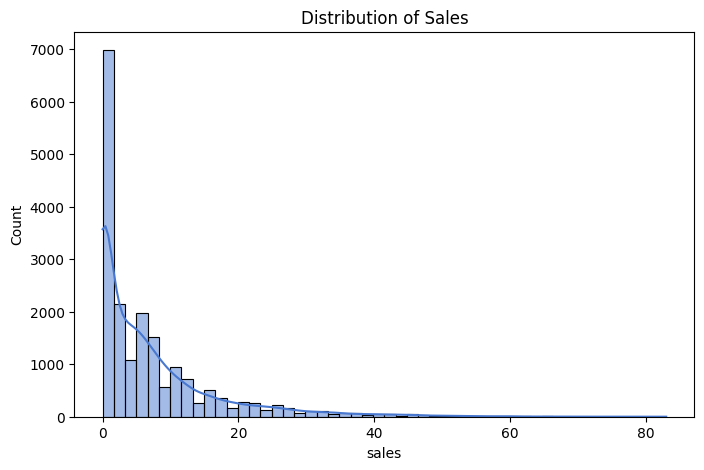

In [ ]:
# Distribution of sales
plt.figure(figsize=(8,5))
sns.histplot(Sales_df['sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/distribution_of_sales.png")
plt.show()

### Zero-sales proportion (important for inventory risk)

In [ ]:
zero_ratio = (Sales_df['sales'] == 0).mean() * 100
print(f"Zero-sales days: {zero_ratio:.2f}%")


Zero-sales days: 31.90%


### Outlier detection

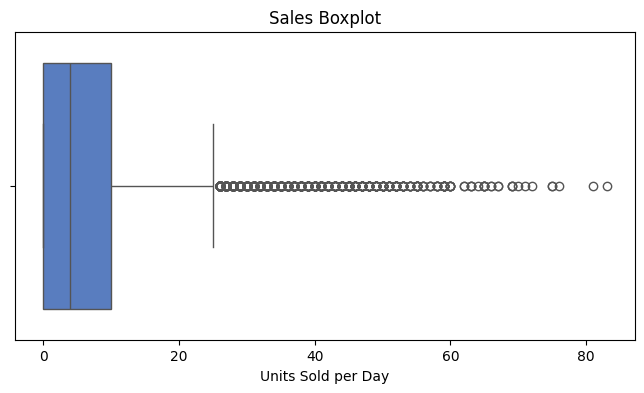

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x='sales', data=Sales_df)
plt.title('Sales Boxplot')
plt.xlabel('Units Sold per Day')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/sales_boxplot.png")
plt.show()

Dissertation insight

Retail demand is sparse and intermittent

High zero-sales frequency motivates safety stock modelling

## Time Series Behaviour (Trend & Seasonality)

Purpose: justify time-series and deep learning models.

### Convert date

In [ ]:
# Convert 'date' to datetime
Sales_df['date'] = pd.to_datetime(Sales_df['date'])

### Aggregate overall sales trend

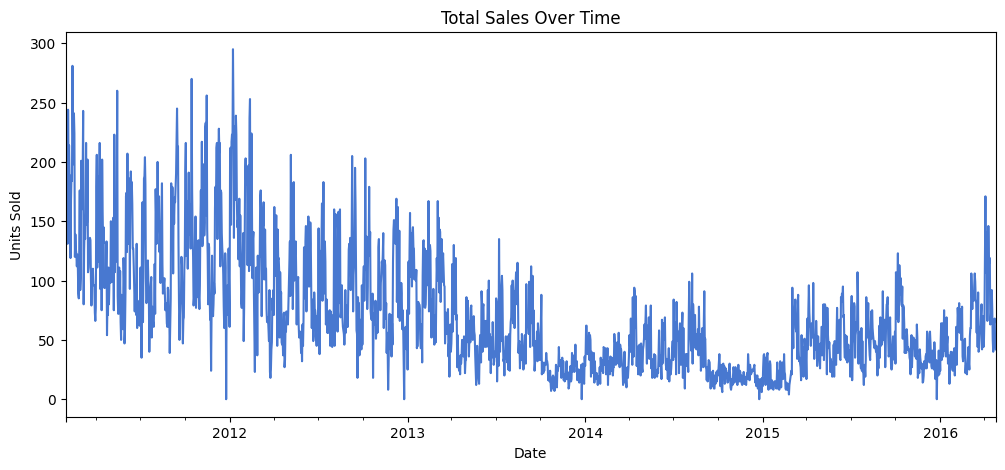

In [ ]:
# Aggregate sales by date and sort
daily_sales = Sales_df.groupby('date')['sales'].sum().sort_index()

# Plot
plt.figure(figsize=(12,5))
daily_sales.plot()
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/total_sales_over_time.png")
plt.show()

In [ ]:
daily_sales.head()

date
2011-01-29    180
2011-01-30    180
2011-01-31    167
2011-02-01    177
2011-02-02    131
Name: sales, dtype: int64

### Rolling mean (trend smoothing)

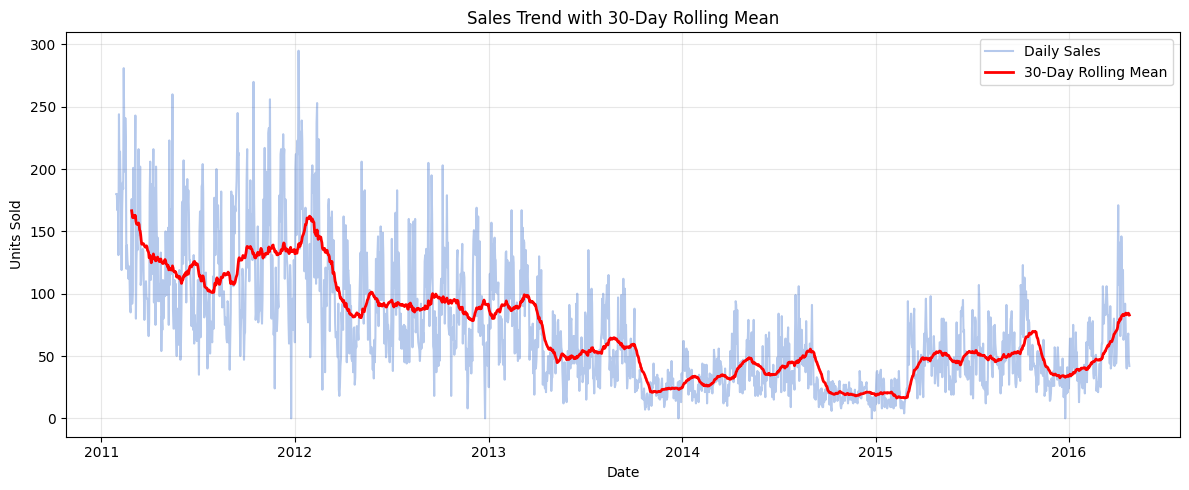

In [ ]:
rolling_30 = daily_sales.rolling(30).mean()

plt.figure(figsize=(12,5))
plt.plot(daily_sales.index, daily_sales.values, alpha=0.4,label='Daily Sales')
plt.plot(rolling_30.index, rolling_30.values,linewidth=2, color='red',label='30-Day Rolling Mean')
plt.title('Sales Trend with 30-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/sales_trend_with_rolling_mean.png")
plt.tight_layout()
plt.show()

Dissertation insight

Clear temporal dependency → forecasting models are appropriate

Rolling trend informs reorder frequency

## Weekly & Yearly Seasonality

Purpose: justify seasonal parameters (e.g. 7-day seasonality).

In [ ]:
Sales_df.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

### Weekly pattern

In [ ]:
# Checking if weekday & number in same order

Weekday = {}
Weekday_number = {}

for i in Sales_df['wday'].unique():
  Weekday = Sales_df[Sales_df['wday']==i]['weekday'].unique()
  Weekday_number = i
  print(f"Weekday {Weekday_number}: {Weekday}")

Weekday 1: ['Saturday']
Weekday 2: ['Sunday']
Weekday 3: ['Monday']
Weekday 4: ['Tuesday']
Weekday 5: ['Wednesday']
Weekday 6: ['Thursday']
Weekday 7: ['Friday']


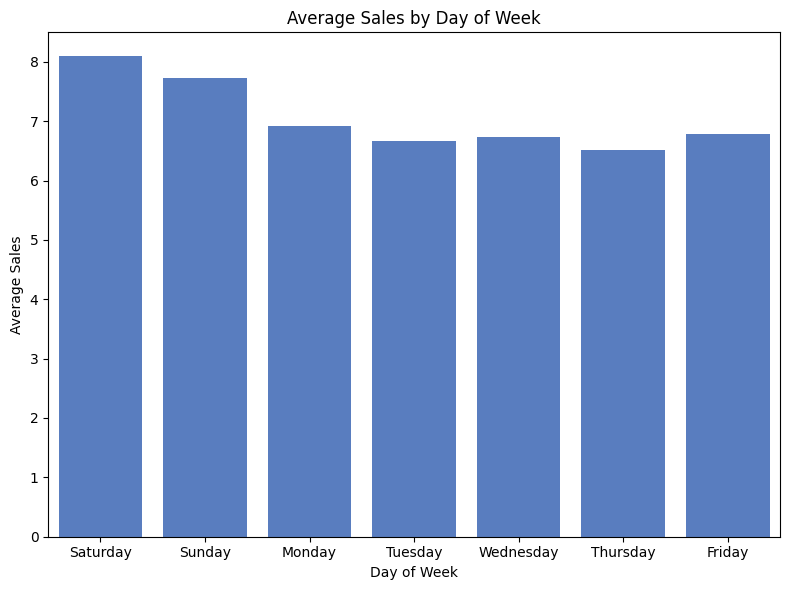

In [ ]:
weekly_pattern = Sales_df.groupby('weekday')['sales'].mean().reindex(Sales_df['weekday']).reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='weekday', y='sales', data=weekly_pattern)
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/average sales by day of week.png")
plt.tight_layout()
plt.show()


### Monthly pattern

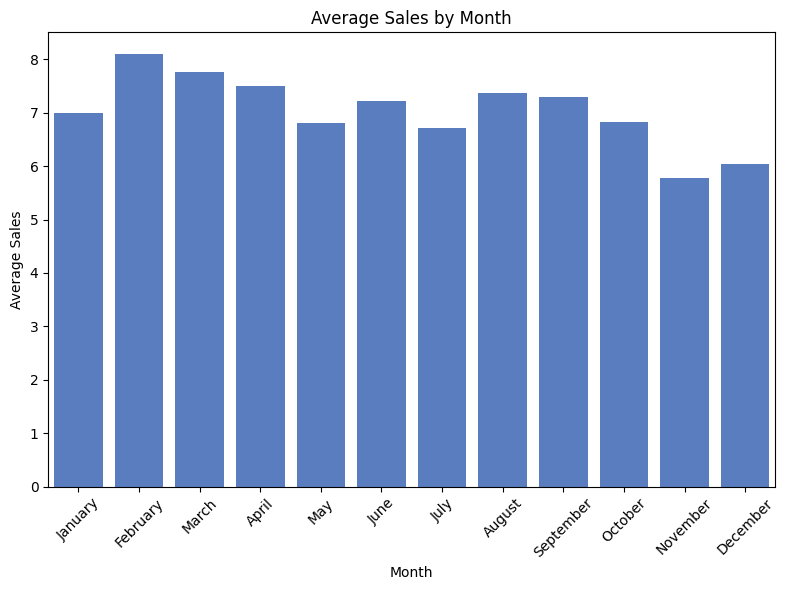

In [ ]:
Sales_df['month_name'] = Sales_df['date'].dt.month_name()

monthly_pattern = Sales_df.groupby('month_name')['sales'].mean().reindex(Sales_df['month_name']).reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='month_name', y='sales', data=monthly_pattern)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/average sales by month.png")
plt.tight_layout()
plt.show()


Dissertation insight

Strong weekly seasonality supports SARIMA and Holt-Winters

Month effects justify calendar features in ML models

## Item level sales Behaviour

Purpose: show demand heterogeneity (important for inventory policy).

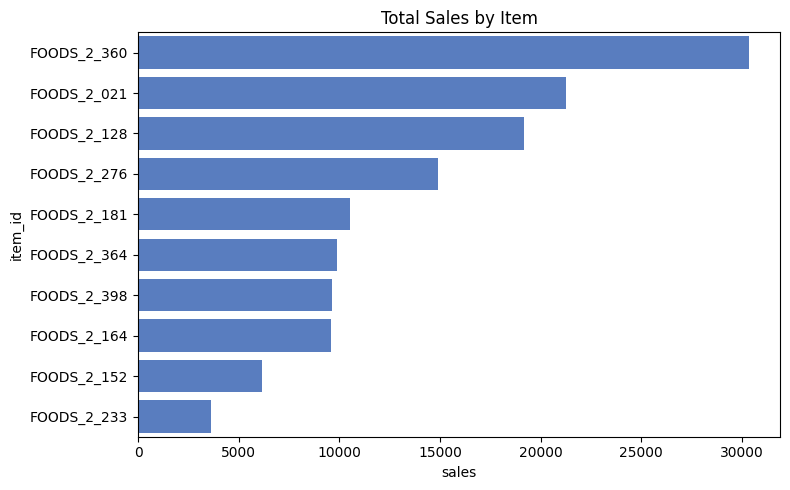

In [ ]:
store_sales = Sales_df.groupby('item_id')['sales'].sum().reset_index()

# Sort in descending order before plotting
store_sales = store_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='sales', y='item_id', data=store_sales)
plt.title('Total Sales by Item')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/total sales by item.png")
plt.tight_layout()
plt.show()

## Price Effect Analysis
Purpose: connect demand forecasting with cost-based inventory decisions.

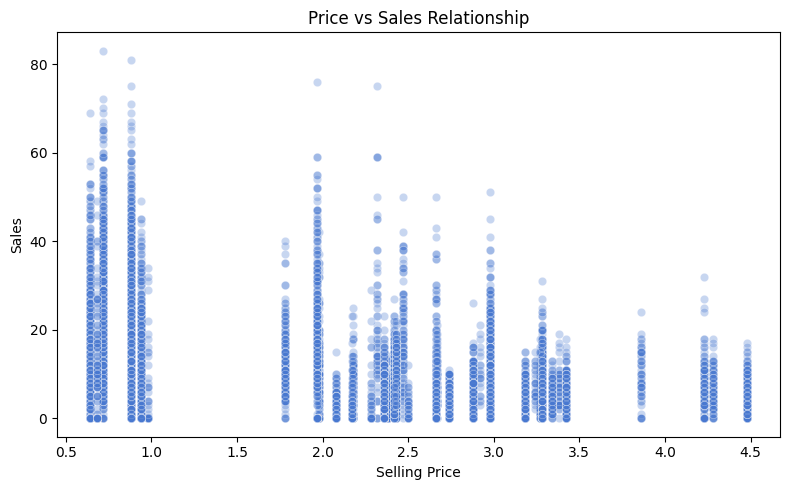

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='sell_price', y='sales', data=Sales_df, alpha=0.3)
plt.title('Price vs Sales Relationship')
plt.xlabel('Selling Price')
plt.ylabel('Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/price vs sales relationship.png")
plt.tight_layout()
plt.show()


Dissertation insight

Price sensitivity affects order quantity decisions

Useful for avoiding overstock on high-price items

## Promotion & Event Impact
Purpose: justify exogenous variables.

### SNAP effect

In [ ]:
Sales_df.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'month_name',
       'price_bin'],
      dtype='object')

In [ ]:
Sales_df['snap_WI'].unique()

array([0, 1])

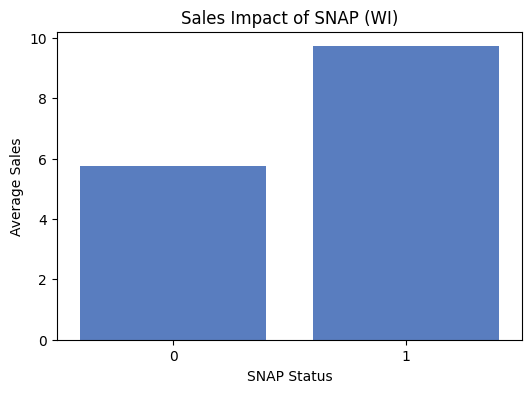

In [ ]:
snap_effect = Sales_df.groupby('snap_WI')['sales'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='snap_WI', y='sales', data=snap_effect)
plt.title('Sales Impact of SNAP (WI)')
plt.xlabel('SNAP Status')
plt.ylabel('Average Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/sales impact of snap (WI).png")
plt.show()


In [ ]:
Sales_df['event_type_1'].unique()

array(['No Event', 'Sporting', 'Cultural', 'National', 'Religious'],
      dtype=object)

In [ ]:
Sales_df['event_name_1'].unique()

array(['No Event', 'SuperBowl', 'ValentinesDay', 'PresidentsDay',
       'LentStart', 'LentWeek2', 'StPatricksDay', 'Purim End',
       'OrthodoxEaster', 'Pesach End', 'Cinco De Mayo', "Mother's day",
       'MemorialDay', 'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [ ]:
Sales_df['event_type_2'].unique()

array(['No Event', 'Cultural', 'Religious'], dtype=object)

In [ ]:
Sales_df['event_name_2'].unique()

array(['No Event', 'Easter', 'Cinco De Mayo', 'OrthodoxEaster',
       "Father's day"], dtype=object)

### Events Effect

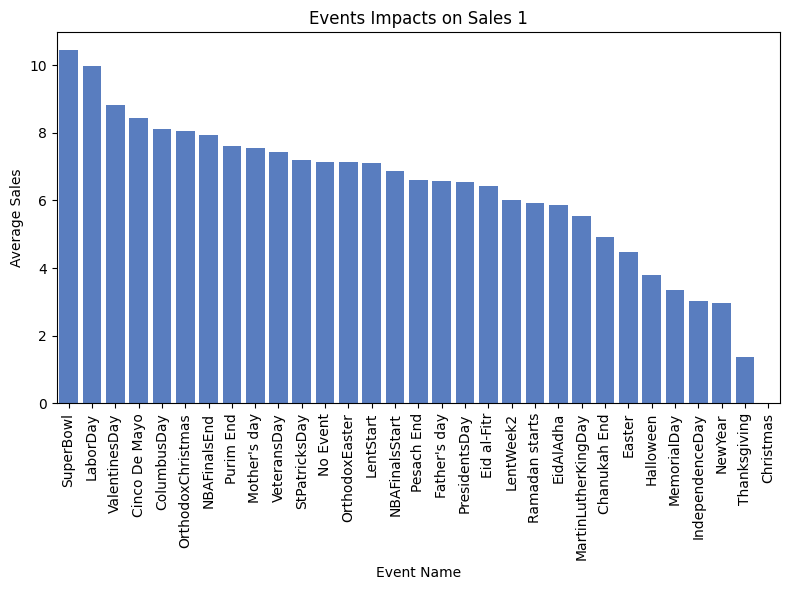

In [ ]:
event_sales = Sales_df.groupby('event_name_1')['sales'].mean().reset_index()

event_sales = event_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='event_name_1', y='sales', data=event_sales)
plt.title('Events Impacts on Sales 1')
plt.xlabel('Event Name')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Events Impacts on Sales 1.png")
plt.tight_layout()
plt.show()


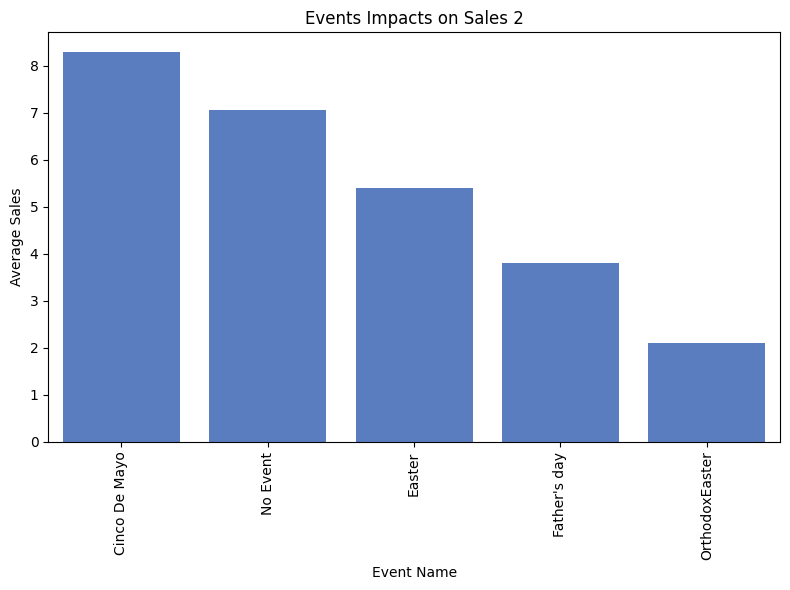

In [ ]:
event_sales = Sales_df.groupby('event_name_2')['sales'].mean().reset_index()

event_sales = event_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='event_name_2', y='sales', data=event_sales)
plt.title('Events Impacts on Sales 2')
plt.xlabel('Event Name')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Events Impacts on Sales 2.png")
plt.tight_layout()
plt.show()

Dissertation insight

Promotions and events significantly influence demand

Ignoring them leads to poor inventory planning

##Correlation Analysis (Numerical Features)

Purpose: feature selection justification.

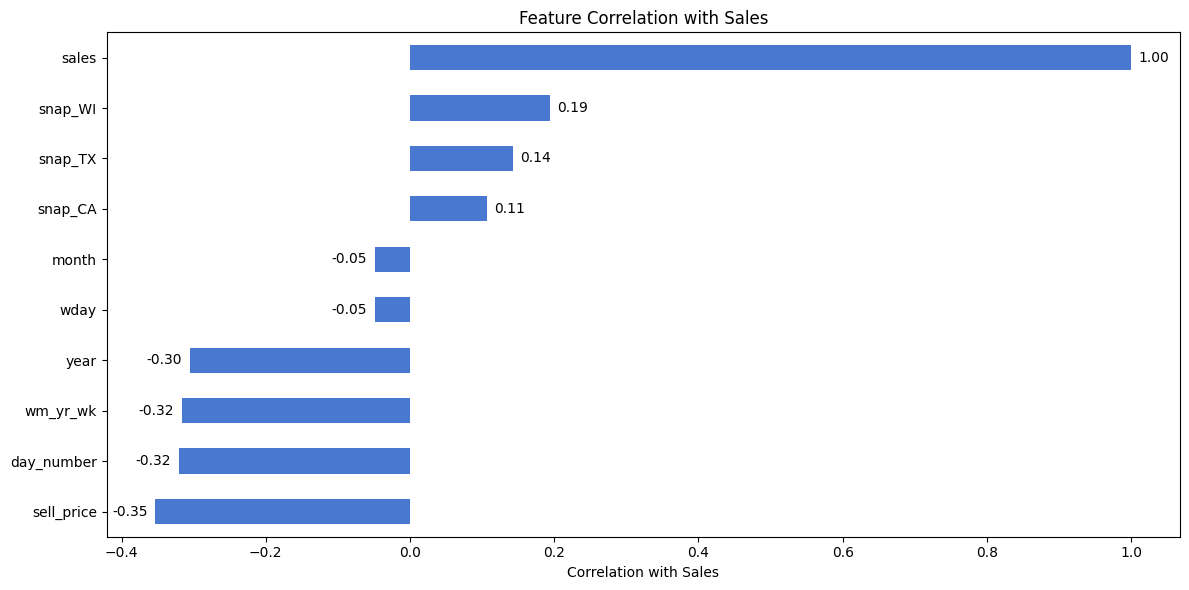

In [ ]:
num_cols = ['sales','sell_price','day_number','wm_yr_wk','wday','month','year','snap_CA','snap_TX','snap_WI']
corr_with_sales = sales_long[num_cols].corr()['sales'].sort_values()

plt.figure(figsize=(12,6))
ax = corr_with_sales.plot(kind='barh')

# Add value labels
for i, v in enumerate(corr_with_sales):
    ax.text(
        v + 0.01 if v > 0 else v - 0.06,  # position
        i,
        f"{v:.2f}",
        va='center'
    )

plt.xlabel('Correlation with Sales')
plt.title('Feature Correlation with Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/feature_correlation_with_sales.png")
plt.tight_layout()
plt.show()

## Data Preprocessing

### Date & Sorting

In [8]:
Sales_df['date'] = pd.to_datetime(Sales_df['date'])
Sales_df = Sales_df.sort_values(['item_id', 'date'])

## Preprocessing for holt winter

In [11]:
# Creating a copy dataset for holt  winter
df_holt_winters = Sales_df.copy()

## Holt-Winters Model

In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Containers
forecast_rows = []
actual_rows = []
eval_rows = []

items = df_holt_winters['item_id'].unique()

for item in items:

    # -----------------------------
    # Prepare time series
    # -----------------------------
    ts = df_holt_winters[df_holt_winters['item_id'] == item] \
            .sort_values('date') \
            .set_index('date')['sales']

    # Log transform (handle skewness)
    ts_log = np.log1p(ts)

    # Train / Test split (last 28 days)
    train = ts_log[:-28]
    test = ts_log[-28:]

    # -----------------------------
    # Fit Holt-Winters
    # -----------------------------
    model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=7
    ).fit()

    # -----------------------------
    # Forecast
    # -----------------------------
    forecast_log = model.forecast(28)

    # Inverse transform
    forecast = np.expm1(forecast_log)
    actual = np.expm1(test)

    # -----------------------------
    # Store forecast & actual tables
    # -----------------------------
    f_df = forecast.to_frame(name=item).T
    f_df.columns = forecast.index
    forecast_rows.append(f_df)

    a_df = actual.to_frame(name=item).T
    a_df.columns = actual.index
    actual_rows.append(a_df)

    # -----------------------------
    # Evaluation metrics
    # -----------------------------
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))

    # WAPE (robust for retail)
    wape = np.sum(np.abs(actual - forecast)) / np.sum(actual) * 100

    # sMAPE (scale-independent)
    smape = np.mean(
        2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast) + 1e-8)
    ) * 100

    # Forecast Bias (over/under forecasting)
    bias = (forecast.sum() - actual.sum()) / actual.sum() * 100

    eval_rows.append({
        'item_id': item,
        'MAE': mae,
        'RMSE': rmse,
        'WAPE (%)': wape,
        'sMAPE (%)': smape,
        'Forecast Bias (%)': bias
    })

# -----------------------------
# Final output tables
# -----------------------------
hw_forecast_table = pd.concat(forecast_rows)
hw_actual_table = pd.concat(actual_rows)
hw_eval_df = pd.DataFrame(eval_rows)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

In [24]:
hw_forecast_table

2016-03-28  2016-03-29  2016-03-30  2016-03-31  2016-04-01  \
FOODS_2_021    6.343091    6.428337    6.730765    6.208585    6.897917   
FOODS_2_128    3.788316    3.689772    3.630833    3.654930    3.893503   
FOODS_2_152    3.372594    3.231505    3.306604    3.164875    3.221351   
FOODS_2_164    3.223811    3.617567    3.225214    3.212574    3.997090   
FOODS_2_181    6.826833    6.996735    6.724761    6.881948    6.959602   
FOODS_2_233    2.695025    2.606535    2.716036    2.664368    2.700524   
FOODS_2_276    2.832462    2.662133    2.769167    2.660824    2.387910   
FOODS_2_360   14.558486   13.869573   15.143345   13.759837   13.132657   
FOODS_2_364    0.658150    0.593968    0.593575    0.604749    0.715955   
FOODS_2_398    5.401913    5.633666    4.999276    5.674584    6.385418   

             2016-04-02  2016-04-03  2016-04-04  2016-04-05  2016-04-06  ...  \
FOODS_2_021    7.692211    6.847000    6.314983    6.399903    6.701173  ...   
FOODS_2_128    4.389240    3.987313    3.772584    3.674364    3.615618  ...   
FOODS_2_152    3.900203    3.975715    3.359491    3.218825    3.293698  ...   
FOODS_2_164    4.310088    3.410985    3.210875    3.603425    3.212274  ...   
FOODS_2_181    7.176845    7.227922    6.804427    6.973844    6.702647  ...   
FOODS_2_233    2.912327    2.672209    2.683367    2.595157    2.704313  ...   
FOODS_2_276    3.222068    4.247810    2.824868    2.654877    2.761698  ...   
FOODS_2_360   15.632076   14.636320   14.542452   13.854248   15.126707  ...   
FOODS_2_364    0.914611    0.712435    0.639529    0.576068    0.575680  ...   
FOODS_2_398    7.691674    6.633996    5.396328    5.627879    4.994042  ...   

             2016-04-15  2016-04-16  2016-04-17  2016-04-18  2016-04-19  \
FOODS_2_021    6.837570    7.625794    6.787042    6.259090    6.343361   
FOODS_2_128    3.861400    4.353885    3.954595    3.741274    3.643698   
FOODS_2_152    3.196089    3.870879    3.945939    3.333402    3.193578   
FOODS_2_164    3.966530    4.277613    3.384009    3.185123    3.575272   
FOODS_2_181    6.914096    7.130097    7.180882    6.759808    6.928256   
FOODS_2_233    2.677211    2.887679    2.649074    2.660162    2.572508   
FOODS_2_276    2.374497    3.205352    4.227033    2.809724    2.640406   
FOODS_2_360   13.103541   15.597811   14.604107   14.510432   13.823646   
FOODS_2_364    0.677633    0.871852    0.674191    0.602914    0.540870   
FOODS_2_398    6.372537    7.676515    6.620682    5.385172    5.616320   

             2016-04-20  2016-04-21  2016-04-22  2016-04-23  2016-04-24  
FOODS_2_021    6.642329    6.126123    6.807569    7.592776    6.757235  
FOODS_2_128    3.585338    3.609198    3.845428    4.336295    3.938316  
FOODS_2_152    3.268003    3.127545    3.183515    3.856282    3.931117  
FOODS_2_164    3.186513    3.173989    3.951319    4.261450    3.370582  
FOODS_2_181    6.658610    6.814452    6.891441    7.106824    7.157463  
FOODS_2_233    2.680976    2.629795    2.665610    2.875414    2.637562  
FOODS_2_276    2.746805    2.639105    2.367810    3.197019    4.216676  
FOODS_2_360   15.093483   13.714249   13.089006   15.580705   14.588025  
FOODS_2_364    0.540490    0.551292    0.658794    0.850832    0.655391  
FOODS_2_398    4.983589    5.657131    6.366106    7.668945    6.614034  

[10 rows x 28 columns]

In [25]:
hw_actual_table

date         2016-03-28  2016-03-29  2016-03-30  2016-03-31  2016-04-01  \
FOODS_2_021         7.0         9.0         2.0         2.0        13.0   
FOODS_2_128         7.0         6.0         2.0         7.0         5.0   
FOODS_2_152         4.0         5.0         3.0         1.0         2.0   
FOODS_2_164         2.0         4.0         5.0         0.0         4.0   
FOODS_2_181         3.0         7.0        11.0        10.0         9.0   
FOODS_2_233         3.0         6.0         4.0         3.0         6.0   
FOODS_2_276         0.0         3.0         1.0         6.0         6.0   
FOODS_2_360        25.0        19.0        13.0        13.0        16.0   
FOODS_2_364         0.0         3.0         0.0         3.0         3.0   
FOODS_2_398         5.0         8.0         3.0         6.0         6.0   

date         2016-04-02  2016-04-03  2016-04-04  2016-04-05  2016-04-06  ...  \
FOODS_2_021        18.0        19.0         9.0        20.0        21.0  ...   
FOODS_2_128        15.0        14.0        10.0        12.0         8.0  ...   
FOODS_2_152         5.0         6.0         8.0         4.0         2.0  ...   
FOODS_2_164        10.0        10.0         4.0         5.0        15.0  ...   
FOODS_2_181        18.0        35.0        14.0        13.0        22.0  ...   
FOODS_2_233         9.0        11.0         1.0        10.0         7.0  ...   
FOODS_2_276         4.0        13.0        11.0         4.0         5.0  ...   
FOODS_2_360        24.0        45.0        34.0        18.0        39.0  ...   
FOODS_2_364         3.0         4.0         6.0         5.0         6.0  ...   
FOODS_2_398        15.0        14.0        10.0        18.0        16.0  ...   

date         2016-04-15  2016-04-16  2016-04-17  2016-04-18  2016-04-19  \
FOODS_2_021         0.0         0.0         2.0         0.0         0.0   
FOODS_2_128         7.0         4.0         5.0         5.0         3.0   
FOODS_2_152         4.0         2.0         6.0         4.0         4.0   
FOODS_2_164         6.0        15.0         4.0         0.0         2.0   
FOODS_2_181        13.0        17.0        26.0        10.0        10.0   
FOODS_2_233         6.0         7.0         5.0         3.0         1.0   
FOODS_2_276         2.0         9.0         3.0        10.0         6.0   
FOODS_2_360        27.0        16.0        11.0        12.0         6.0   
FOODS_2_364         5.0         6.0         7.0         1.0         5.0   
FOODS_2_398         8.0        16.0         7.0         5.0         3.0   

date         2016-04-20  2016-04-21  2016-04-22  2016-04-23  2016-04-24  
FOODS_2_021         0.0         1.0         0.0         0.0         0.0  
FOODS_2_128         8.0         2.0         2.0         5.0         3.0  
FOODS_2_152         1.0         3.0         7.0         1.0         5.0  
FOODS_2_164         0.0         2.0         9.0         3.0         2.0  
FOODS_2_181         5.0         9.0        11.0         8.0         4.0  
FOODS_2_233         6.0         8.0         5.0         3.0         4.0  
FOODS_2_276         4.0         7.0         4.0         7.0         9.0  
FOODS_2_360        19.0        25.0        17.0        14.0         6.0  
FOODS_2_364         1.0         3.0         4.0         2.0         5.0  
FOODS_2_398        18.0         5.0         9.0         3.0         4.0  

[10 rows x 28 columns]

In [23]:
hw_eval_df

item_id       MAE       RMSE   WAPE (%)   sMAPE (%)  Forecast Bias (%)
0  FOODS_2_021  5.860631   6.806383  94.309004  113.733688           7.673102
1  FOODS_2_128  4.298915   6.090465  58.716887   67.445195         -47.577475
2  FOODS_2_152  1.504159   1.839420  39.361176   42.819986         -10.156986
3  FOODS_2_164  3.299101   4.567387  58.097370   70.621442         -37.482668
4  FOODS_2_181  7.193747   9.532621  53.713311   61.287648         -48.207443
5  FOODS_2_233  3.683363   4.836550  59.961725   71.980289         -56.175824
6  FOODS_2_276  3.504114   4.244272  58.751608   74.084618         -50.419389
7  FOODS_2_360  9.919884  13.445705  44.370086   47.102831         -35.740663
8  FOODS_2_364  3.218513   3.739714  85.017318  137.579253         -82.655574
9  FOODS_2_398  4.905669   6.343477  50.130924   54.613830         -38.166579

## Model Evaluation

In [19]:
# Overall (average across items)
overall_hw_metrics = hw_eval_df[
    ['MAE', 'RMSE', 'WAPE (%)', 'sMAPE (%)', 'Forecast Bias (%)']
].mean()

print("Holt-Winters Overall Performance:\n")
print(overall_hw_metrics)

Holt-Winters Overall Performance:

MAE                   4.738810
RMSE                  6.144599
WAPE (%)             60.242941
sMAPE (%)            74.126878
Forecast Bias (%)   -39.890950
dtype: float64


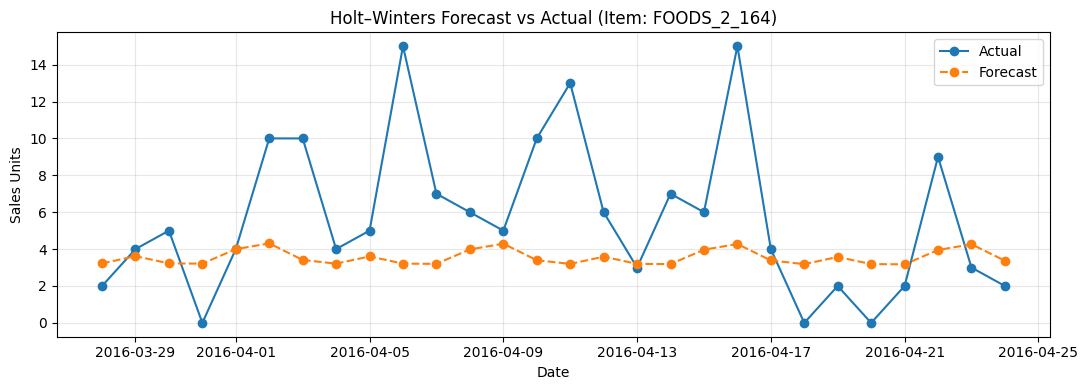

In [21]:
example_item = hw_forecast_table.index[3]

actual = hw_actual_table.loc[example_item]
forecast = hw_forecast_table.loc[example_item]

dates = actual.index  # forecast horizon dates

plt.figure(figsize=(11,4))

plt.plot(dates, actual.values, marker='o', label='Actual')
plt.plot(dates, forecast.values, marker='o', linestyle='--', label='Forecast')

plt.title(f'Holt–Winters Forecast vs Actual (Item: {example_item})')
plt.xlabel('Date')
plt.ylabel('Sales Units')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


##SARIMA Model

In [38]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ------------------------
# Containers
# ------------------------
sarima_forecast_rows = []
sarima_actual_rows = []
sarima_eval_rows = []

# ------------------------
# Items
# ------------------------
items = Sales_df['item_id'].unique()

# ------------------------
# SARIMA Modeling
# ------------------------
for item in items:
    # ---- Prepare time series ----
    ts = Sales_df[Sales_df['item_id'] == item].sort_values('date')
    ts = ts.set_index('date')['sales']

    # Optional: log transform if skewed
    ts_log = np.log1p(ts)

    # Train/Test split (last 28 days)
    train = ts_log[:-28]
    test = ts_log[-28:]

    # ---- Fit SARIMA ----
    sarima_model = SARIMAX(train,
                            order=(1,1,1),
                            seasonal_order=(1,1,1,7),
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit(disp=False)

    # ---- Forecast ----
    forecast_log = sarima_model.forecast(28)
    forecast = np.expm1(forecast_log)  # inverse log1p
    actual = ts[-28:]

    # ---- Store forecast & actual as table format ----
    forecast_df = forecast.to_frame(name=item).T
    forecast_df.columns = forecast.index
    sarima_forecast_rows.append(forecast_df)

    actual_df = actual.to_frame(name=item).T
    actual_df.columns = actual.index
    sarima_actual_rows.append(actual_df)

    # ---- Evaluation Metrics ----
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    wape = np.sum(np.abs(actual - forecast)) / np.sum(actual) * 100
    smape = np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))) * 100
    bias = np.sum(forecast - actual) / np.sum(actual) * 100

    sarima_eval_rows.append({
        'item_id': item,
        'MAE': mae,
        'RMSE': rmse,
        'WAPE (%)': wape,
        'sMAPE (%)': smape,
        'Forecast Bias (%)': bias
    })

# ------------------------
# Final Tables
# ------------------------
sarima_forecast_table = pd.concat(sarima_forecast_rows)
sarima_actual_table = pd.concat(sarima_actual_rows)
sarima_eval_df = pd.DataFrame(sarima_eval_rows)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

In [40]:
# Overall Metrics
overall_sarima_metrics = sarima_eval_df[['MAE','RMSE','WAPE (%)','sMAPE (%)','Forecast Bias (%)']].mean()
print("SARIMA Overall Metrics:\n", overall_sarima_metrics)

SARIMA Overall Metrics:
 MAE                   4.696815
RMSE                  6.110794
WAPE (%)             59.656052
sMAPE (%)            73.035935
Forecast Bias (%)   -40.773518
dtype: float64


## Evaluation Metrics

In [57]:
example_item = sarima_forecast_table.index[3]
example_item

'FOODS_2_164'

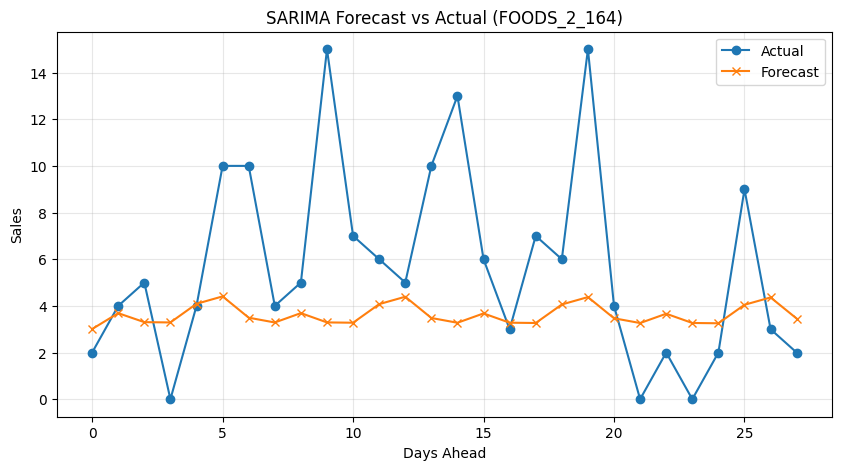

In [41]:
# ------------------------
# Example Item Forecast Plot
# ------------------------
example_item = sarima_forecast_table.index[3]

plt.figure(figsize=(10,5))
plt.plot(sarima_actual_table.loc[example_item].values, label='Actual', marker='o')
plt.plot(sarima_forecast_table.loc[example_item].values, label='Forecast', marker='x')
plt.title(f'SARIMA Forecast vs Actual ({example_item})')
plt.xlabel('Days Ahead')
plt.ylabel('Sales')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

###  LSTM Model

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# ------------------------
# Containers
# ------------------------
lstm_forecast_rows = []
lstm_actual_rows = []
lstm_eval_rows = []

# ------------------------
# Sequence generation function
# ------------------------
def create_sequences(data, window_size=28):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# ------------------------
# Modeling for each item
# ------------------------
items = Sales_df['item_id'].unique()

for item in items:
    ts = Sales_df[Sales_df['item_id']==item].sort_values('date')
    ts = ts.set_index('date')['sales'].values.reshape(-1,1)

    # Log transform (optional for skewed data)
    ts = np.log1p(ts)

    # Normalize
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts)

    # Train/val split
    train_size = int(len(ts_scaled)*0.8)
    train, val = ts_scaled[:train_size], ts_scaled[train_size:]

    X_train, y_train = create_sequences(train)
    X_val, y_val = create_sequences(val)

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # ---- Build LSTM ----
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=0)

    # ---- Forecast ----
    y_pred_scaled = model.predict(X_val)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_val)

    # Convert to original scale
    y_pred = np.expm1(y_pred)
    y_true = np.expm1(y_true)

    # ---- Store forecast table ----
    forecast_df = pd.DataFrame([y_pred.flatten()], columns=range(1, len(y_pred)+1), index=[item])
    actual_df = pd.DataFrame([y_true.flatten()], columns=range(1, len(y_true)+1), index=[item])
    lstm_forecast_rows.append(forecast_df)
    lstm_actual_rows.append(actual_df)

    # ---- Evaluation Metrics ----
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    wape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
    bias = np.sum(y_pred - y_true) / np.sum(y_true) * 100

    lstm_eval_rows.append({
        'item_id': item,
        'MAE': mae,
        'RMSE': rmse,
        'WAPE (%)': wape,
        'sMAPE (%)': smape,
        'Forecast Bias (%)': bias
    })

# ------------------------
# Final Tables
# ------------------------
lstm_forecast_table = pd.concat(lstm_forecast_rows)
lstm_actual_table = pd.concat(lstm_actual_rows)
lstm_eval_df = pd.DataFrame(lstm_eval_rows)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


## Evaluation Metrics

In [45]:
overall_lstm_metrics = lstm_eval_df[['MAE','RMSE','WAPE (%)','sMAPE (%)','Forecast Bias (%)']].mean()
print("LSTM Overall Metrics:\n", overall_lstm_metrics)

LSTM Overall Metrics:
 MAE                   2.663865
RMSE                  3.916432
WAPE (%)             53.992459
sMAPE (%)            91.211405
Forecast Bias (%)   -13.823016
dtype: float64


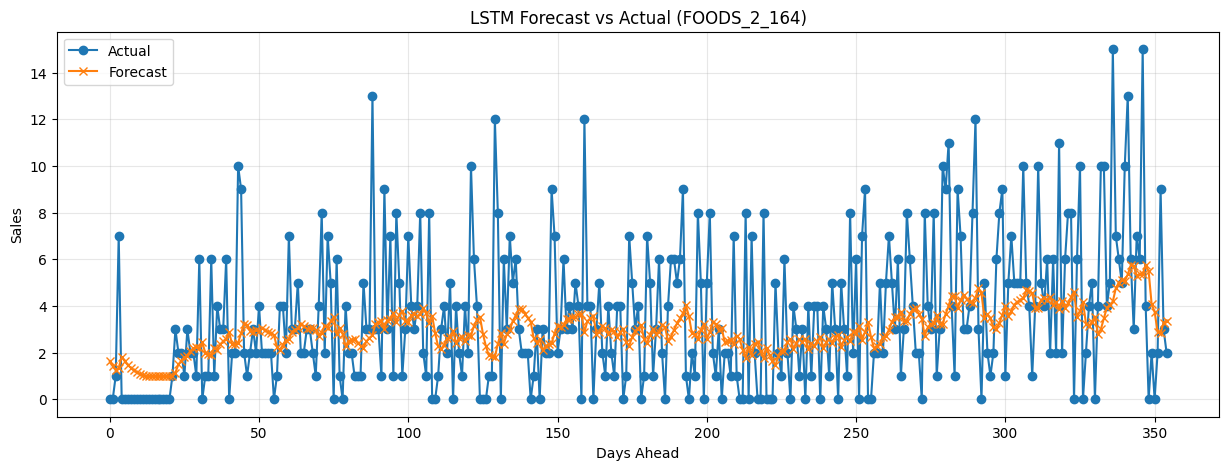

In [48]:
# ------------------------
# Example Item Plot
# ------------------------
example_item = lstm_forecast_table.index[3]

plt.figure(figsize=(15,5))
plt.plot(lstm_actual_table.loc[example_item].values, label='Actual', marker='o')
plt.plot(lstm_forecast_table.loc[example_item].values, label='Forecast', marker='x')
plt.title(f'LSTM Forecast vs Actual ({example_item})')
plt.xlabel('Days Ahead')
plt.ylabel('Sales')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## GRU Model

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# ------------------------
# Containers
# ------------------------
gru_forecast_rows = []
gru_actual_rows = []
gru_eval_rows = []

# ------------------------
# Sequence generation
# ------------------------
def create_sequences(data, window_size=28):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# ------------------------
# Modeling for each item
# ------------------------
items = Sales_df['item_id'].unique()

for item in items:
    ts = Sales_df[Sales_df['item_id']==item].sort_values('date')
    ts = ts.set_index('date')['sales'].values.reshape(-1,1)

    # Log transform (optional for skewed data)
    ts = np.log1p(ts)

    # Normalize
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts)

    # Train/val split
    train_size = int(len(ts_scaled)*0.8)
    train, val = ts_scaled[:train_size], ts_scaled[train_size:]

    X_train, y_train = create_sequences(train)
    X_val, y_val = create_sequences(val)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # ---- Build GRU ----
    model = Sequential()
    model.add(GRU(64, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=0)

    # ---- Forecast ----
    y_pred_scaled = model.predict(X_val)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_val)

    # Inverse log transform
    y_pred = np.expm1(y_pred)
    y_true = np.expm1(y_true)

    # ---- Store forecast table ----
    forecast_df = pd.DataFrame([y_pred.flatten()], columns=range(1, len(y_pred)+1), index=[item])
    actual_df = pd.DataFrame([y_true.flatten()], columns=range(1, len(y_true)+1), index=[item])
    gru_forecast_rows.append(forecast_df)
    gru_actual_rows.append(actual_df)

    # ---- Evaluation metrics ----
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    wape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
    bias = np.sum(y_pred - y_true) / np.sum(y_true) * 100

    gru_eval_rows.append({
        'item_id': item,
        'MAE': mae,
        'RMSE': rmse,
        'WAPE (%)': wape,
        'sMAPE (%)': smape,
        'Forecast Bias (%)': bias
    })

# ------------------------
# Final tables
# ------------------------
gru_forecast_table = pd.concat(gru_forecast_rows)
gru_actual_table = pd.concat(gru_actual_rows)
gru_eval_df = pd.DataFrame(gru_eval_rows)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [50]:
overall_gru_metrics = gru_eval_df[['MAE','RMSE','WAPE (%)','sMAPE (%)','Forecast Bias (%)']].mean()
print("GRU Overall Metrics:\n", overall_gru_metrics)

GRU Overall Metrics:
 MAE                   2.700054
RMSE                  3.941489
WAPE (%)             54.732088
sMAPE (%)            91.791265
Forecast Bias (%)   -11.272362
dtype: float64


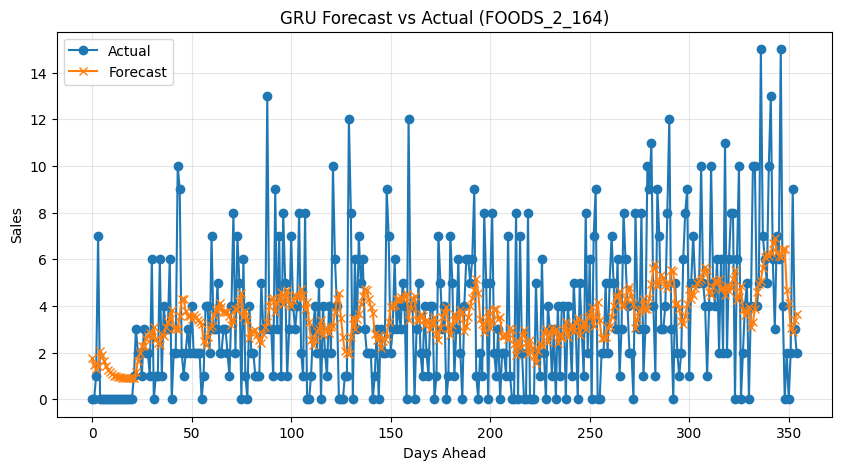

In [52]:
# ------------------------
# Example Item Plot
# ------------------------
example_item = gru_forecast_table.index[3]

plt.figure(figsize=(10,5))
plt.plot(gru_actual_table.loc[example_item].values, label='Actual', marker='o')
plt.plot(gru_forecast_table.loc[example_item].values, label='Forecast', marker='x')
plt.title(f'GRU Forecast vs Actual ({example_item})')
plt.xlabel('Days Ahead')
plt.ylabel('Sales')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Comparison

In [53]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# ------------------------
# Assume we already have these DataFrames:
# hw_eval_df, sarima_eval_df, lstm_eval_df, gru_eval_df
# Each with columns: ['item_id','MAE','RMSE','WAPE (%)','sMAPE (%)','Forecast Bias (%)']
# ------------------------

# 1. Calculate overall mean metrics for each model
overall_metrics = pd.DataFrame({
    'Model': ['Holt-Winters', 'SARIMA', 'LSTM', 'GRU'],
    'MAE': [hw_eval_df['MAE'].mean(),
            sarima_eval_df['MAE'].mean(),
            lstm_eval_df['MAE'].mean(),
            gru_eval_df['MAE'].mean()],
    'RMSE': [hw_eval_df['RMSE'].mean(),
             sarima_eval_df['RMSE'].mean(),
             lstm_eval_df['RMSE'].mean(),
             gru_eval_df['RMSE'].mean()],
    'WAPE (%)': [hw_eval_df['WAPE (%)'].mean(),
                 sarima_eval_df['WAPE (%)'].mean(),
                 lstm_eval_df['WAPE (%)'].mean(),
                 gru_eval_df['WAPE (%)'].mean()],
    'sMAPE (%)': [hw_eval_df['sMAPE (%)'].mean(),
                  sarima_eval_df['sMAPE (%)'].mean(),
                  lstm_eval_df['sMAPE (%)'].mean(),
                  gru_eval_df['sMAPE (%)'].mean()],
    'Forecast Bias (%)': [hw_eval_df['Forecast Bias (%)'].mean(),
                          sarima_eval_df['Forecast Bias (%)'].mean(),
                          lstm_eval_df['Forecast Bias (%)'].mean(),
                          gru_eval_df['Forecast Bias (%)'].mean()]
})

# 2. Rank models based on a key metric (lower is better)
metric_to_rank = 'sMAPE (%)'
overall_metrics['Rank'] = overall_metrics[metric_to_rank].rank(method='min', ascending=True)

# 3. Highlight the best model row
def highlight_best(row):
    if row['Rank'] == 1:
        return ['background-color: lightgreen; font-weight: bold']*len(row)
    else:
        return ['']*len(row)

# 4. Display styled table
styled_table = overall_metrics.style.apply(highlight_best, axis=1).format("{:.2f}", subset=['MAE','RMSE','WAPE (%)','sMAPE (%)','Forecast Bias (%)'])
display(styled_table)


### **Evaluation Metrics Explained**

1. **MAE (Mean Absolute Error):**

   * Measures the average magnitude of errors between forecasted and actual sales, ignoring the direction.
   * Lower MAE indicates predictions are closer to actual values.

2. **RMSE (Root Mean Squared Error):**

   * Similar to MAE but penalizes larger errors more heavily due to squaring.
   * Sensitive to outliers. Lower RMSE is better.

3. **WAPE (Weighted Absolute Percentage Error):**

   * Measures forecast error relative to the actual total sales, expressed as a percentage.
   * Lower WAPE indicates better accuracy across items with different sales volumes.

4. **sMAPE (Symmetric Mean Absolute Percentage Error):**

   * Percentage error that treats over- and under-forecasting symmetrically.
   * Lower sMAPE indicates better predictive performance.

5. **Forecast Bias (%):**

   * Indicates whether the model tends to over-forecast (+) or under-forecast (−).
   * A value near 0 is ideal; negative values show systematic under-forecasting.

6. **Rank:**

   * Shows overall performance order based on a selected metric or combination of metrics.
   * Rank 1 is best, Rank 4 is worst in this table.

---

### **Insights from the Table**

1. **SARIMA has the best overall performance (Rank 1):**

   * Lowest MAE (4.70) and RMSE (6.11), meaning its forecasts are closest to actual values on average.
   * Slightly lower WAPE (59.66%) and sMAPE (73.04%) than other models, suggesting good consistency across different sales levels.
   * Forecast Bias is -40.77%, indicating it slightly under-forecasts systematically.

2. **Holt-Winters is competitive (Rank 2):**

   * MAE and RMSE slightly higher than SARIMA.
   * sMAPE and Forecast Bias are worse than SARIMA, meaning it is slightly less accurate for high/low variations.

3. **LSTM and GRU have lower MAE and RMSE individually, but worse sMAPE and WAPE:**

   * Shows that while deep learning models predict better on average per observation, they may overfit or underperform for low-sales items.
   * LSTM has a Forecast Bias of -13.82% and GRU -11.27%, closer to 0 than SARIMA/Holt-Winters, suggesting less under-forecasting.

4. **Trade-offs:**

   * Classical models (SARIMA, Holt-Winters) perform better for overall accuracy and weighted errors, suitable for inventory planning across all items.
   * Deep learning models (LSTM, GRU) may capture short-term fluctuations but have higher percentage errors relative to total sales, making them less reliable for inventory decisions where high and low-demand items coexist.

**Conclusion:**

* **SARIMA** is the most balanced model for your dataset in terms of accuracy (MAE, RMSE, WAPE, sMAPE) and can be prioritized for forecasting across all items.
* Deep learning models could be considered for high-demand, highly volatile items individually, but caution is needed for inventory planning.


## Select the best forecast model

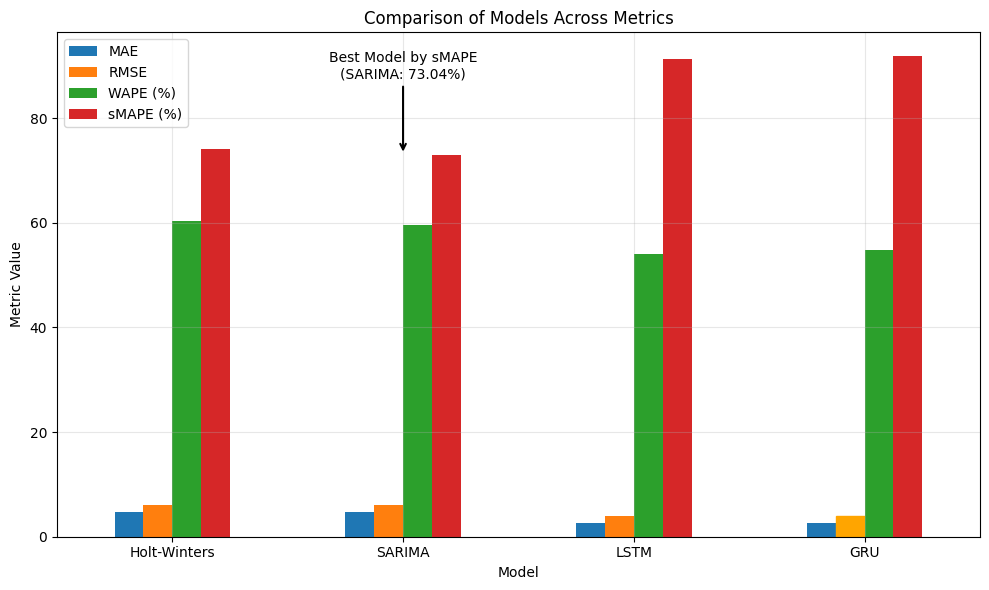

In [56]:
import matplotlib.pyplot as plt

# Set index
df_plot = overall_metrics.set_index('Model')[['MAE','RMSE','WAPE (%)','sMAPE (%)']]

# Identify best model according to sMAPE
best_model = df_plot['sMAPE (%)'].idxmin()
best_value = df_plot.loc[best_model, 'sMAPE (%)']

# Plot
ax = df_plot.plot(kind='bar', figsize=(10,6))

# Highlight best model bar for sMAPE
for i, model in enumerate(df_plot.index):
    if model == best_model:
        ax.patches[i*len(df_plot.columns) + list(df_plot.columns).index('sMAPE (%)')].set_color('orange')

# Annotate
plt.annotate(
    f"Best Model by sMAPE\n({best_model}: {best_value:.2f}%)",
    xy=(list(df_plot.index).index(best_model), best_value),
    xytext=(list(df_plot.index).index(best_model), best_value + best_value*0.2),
    arrowprops=dict(facecolor='black', arrowstyle="->", lw=1.5),
    fontsize=10,
    ha='center'
)

plt.title('Comparison of Models Across Metrics')
plt.ylabel('Metric Value')
plt.xticks(rotation=0)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Hyperparameter Tuning

In [77]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Example: select one item for tuning
item = 'FOODS_2_164'
ts = Sales_df[Sales_df['item_id'] == item].sort_values('date')
ts = ts.set_index('date')['sales']

# Log-transform to reduce skewness
ts_log = np.log1p(ts)

# Train/Validation split (last 28 days as validation)
train = ts_log[:-28]
val = ts_log[-28:]

p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
s = [7]  # weekly seasonality

import itertools
params = list(itertools.product(p,d,q))
seasonal_params = list(itertools.product(P,D,Q,s))

best_smape = np.inf
best_order = None
best_seasonal_order = None

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

for param in params:
    for seasonal_param in seasonal_params:
        try:
            model = SARIMAX(train, order=param, seasonal_order=seasonal_param,
                            enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)

            forecast_log = results.forecast(28)
            forecast = np.expm1(forecast_log)
            actual = np.expm1(val)

            val_smape = smape(actual, forecast)

            if val_smape < best_smape:
                best_smape = val_smape
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print(f'Best SARIMA params: order={best_order}, seasonal_order={best_seasonal_order}, sMAPE={best_smape:.2f}%')


Best SARIMA params: order=(1, 1, 1), seasonal_order=(1, 0, 0, 7), sMAPE=69.31%


In [78]:
import pandas as pd

# Suppose best_params is a dictionary
best_params = {'order': best_order, 'seasonal_order': best_seasonal_order}

# Convert to DataFrame
df_params = pd.DataFrame({
    'order': pd.Series(best_params['order'], index=['p', 'd', 'q']),
    'seasonal_order': pd.Series(best_params['seasonal_order'], index=['P', 'D', 'Q', 's'])
})

# Save to CSV
df_params.to_csv("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/sarima_best_params.csv")
df_params


order  seasonal_order
D    NaN             0.0
P    NaN             1.0
Q    NaN             0.0
d    1.0             NaN
p    1.0             NaN
q    1.0             NaN
s    NaN             7.0

In [87]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ------------------------
# Containers
# ------------------------
sarima_tuned_forecast_rows = []
sarima_tuned_actual_rows = []
sarima_tuned_eval_rows = []

# ------------------------
# Items
# ------------------------
items = Sales_df['item_id'].unique()

# ------------------------
# SARIMA Modeling
# ------------------------
for item in items:
    # ---- Prepare time series ----
    ts = Sales_df[Sales_df['item_id'] == item].sort_values('date')
    ts = ts.set_index('date')['sales']

    # Optional: log transform if skewed
    ts_log = np.log1p(ts)

    # Train/Test split (last 28 days)
    train = ts_log[:-28]
    test = ts_log[-28:]

    # ---- Fit SARIMA ----
    sarima_model_tuned = SARIMAX(train,
                            order=(1,1,1),
                            seasonal_order=(1,0,0,7),
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit(disp=False)

    # ---- Forecast ----
    forecast_log_tuned = sarima_model_tuned.forecast(28)
    forecast_tuned = np.expm1(forecast_log_tuned)  # inverse log1p
    actual = ts[-28:]

    # ---- Store forecast & actual as table format ----
    forecast_df_tuned = forecast_tuned.to_frame(name=item).T
    forecast_df_tuned.columns = forecast_tuned.index
    sarima_tuned_forecast_rows.append(forecast_df_tuned)

    actual_df = actual.to_frame(name=item).T
    actual_df.columns = actual.index
    sarima_tuned_actual_rows.append(actual_df)

    # ---- Evaluation Metrics ----
    mae = mean_absolute_error(actual, forecast_tuned)
    rmse = np.sqrt(mean_squared_error(actual, forecast_tuned))
    wape = np.sum(np.abs(actual - forecast_tuned)) / np.sum(actual) * 100
    smape = np.mean(2 * np.abs(forecast_tuned - actual) / (np.abs(actual) + np.abs(forecast_tuned))) * 100
    bias = np.sum(forecast_tuned - actual) / np.sum(actual) * 100

    sarima_tuned_eval_rows.append({
        'item_id': item,
        'MAE': mae,
        'RMSE': rmse,
        'WAPE (%)': wape,
        'sMAPE (%)': smape,
        'Forecast Bias (%)': bias
    })

# ------------------------
# Final Tables
# ------------------------
sarima_forecast_table_tuned = pd.concat(sarima_tuned_forecast_rows)
sarima_actual_table_tuned = pd.concat(sarima_tuned_actual_rows)
sarima_eval_df_tuned = pd.DataFrame(sarima_tuned_eval_rows)


In [88]:
# Overall Metrics
sarima_tuned_metrics = sarima_eval_df_tuned[['MAE','RMSE','WAPE (%)','sMAPE (%)','Forecast Bias (%)']].mean()
print("SARIMA Overall Metrics:\n", sarima_tuned_metrics)


SARIMA Overall Metrics:
 MAE                   4.669080
RMSE                  6.110677
WAPE (%)             59.167568
sMAPE (%)            71.290026
Forecast Bias (%)   -39.039739
dtype: float64


In [91]:
# Round metrics for clarity
overall_sarima_metrics = overall_sarima_metrics.round(3)
overall_sarima_metrics.name = 'Initial SARIMA'

tuned_metrics = sarima_tuned_metrics.round(3)
tuned_metrics.name = 'Tuned SARIMA'

# Combine for side-by-side comparison
comparison_df = pd.concat([overall_sarima_metrics, tuned_metrics], axis=1)

# Add a 'Difference' column (Tuned - Initial)
comparison_df['Difference'] = comparison_df['Tuned SARIMA'] - comparison_df['Initial SARIMA']

print("Comparison of Initial vs Tuned SARIMA Metrics:\n")
comparison_df


Comparison of Initial vs Tuned SARIMA Metrics:



Initial SARIMA  Tuned SARIMA  Difference
MAE                         4.994         4.669      -0.325
RMSE                        6.465         6.111      -0.354
WAPE (%)                   60.697        59.168      -1.529
sMAPE (%)                  75.501        71.290      -4.211
Forecast Bias (%)         -47.148       -39.040       8.108

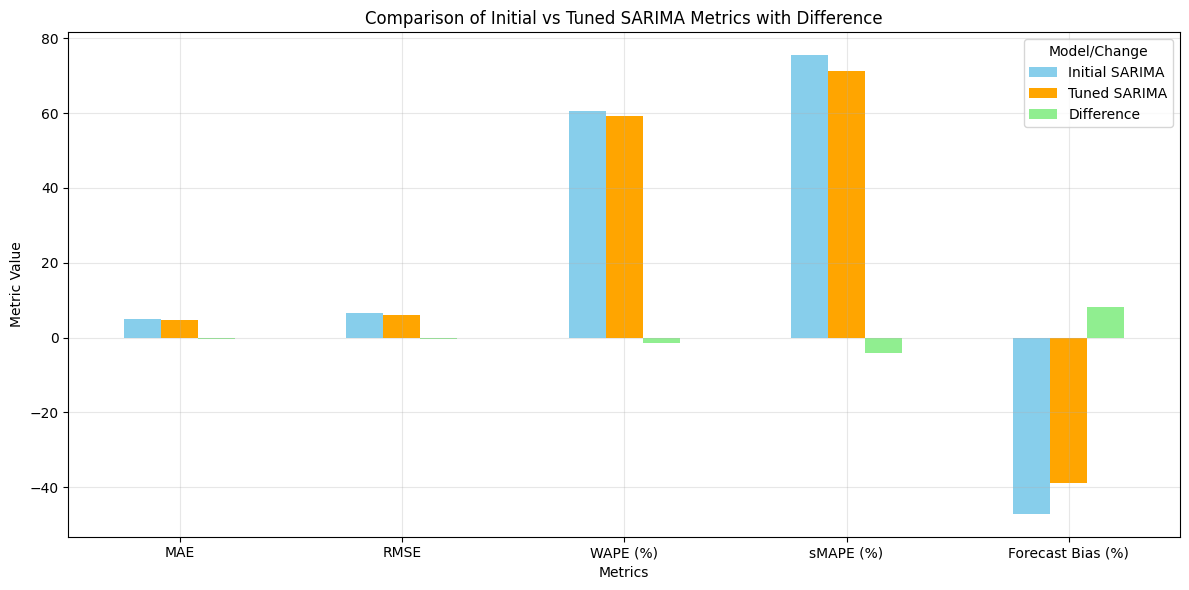

In [92]:
import matplotlib.pyplot as plt

# Transpose for better plotting (metrics on x-axis)
plot_df = comparison_df.T[['MAE','RMSE','WAPE (%)','sMAPE (%)','Forecast Bias (%)']].T
plot_df[['Initial SARIMA','Tuned SARIMA','Difference']] = comparison_df[['Initial SARIMA','Tuned SARIMA','Difference']]

# Plot
ax = plot_df[['Initial SARIMA','Tuned SARIMA','Difference']].plot(kind='bar', figsize=(12,6), color=['skyblue','orange','lightgreen'])
plt.title('Comparison of Initial vs Tuned SARIMA Metrics with Difference')
plt.ylabel('Metric Value')
plt.xlabel('Metrics')
plt.xticks(rotation=0)
plt.grid(alpha=0.3)
plt.legend(title='Model/Change')
plt.tight_layout()
plt.show()


##Convert forecast → inventory inputs

In [95]:
sarima_forecast_table_tuned

2016-03-28  2016-03-29  2016-03-30  2016-03-31  2016-04-01  \
FOODS_2_021    6.354455    6.453274    6.522312    6.396663    6.346354   
FOODS_2_128    4.125736    3.975148    3.804474    4.145072    3.975428   
FOODS_2_152    3.178631    2.999600    2.955641    2.946030    2.942863   
FOODS_2_164    3.377164    3.871782    3.903601    3.488572    3.856274   
FOODS_2_181    7.061430    7.130428    7.138052    7.132623    7.130347   
FOODS_2_233    3.183952    3.081290    3.067502    3.065543    3.064827   
FOODS_2_276    3.573823    3.668757    3.239233    3.658633    3.552855   
FOODS_2_360   13.884758   14.117348   14.196463   14.208613   14.228207   
FOODS_2_364    0.753371    0.794703    0.798592    0.792550    0.798679   
FOODS_2_398    5.568577    5.975824    6.018741    6.047814    6.142509   

             2016-04-02  2016-04-03  2016-04-04  2016-04-05  2016-04-06  ...  \
FOODS_2_021    6.340175    6.408821    6.404353    6.403146    6.402312  ...   
FOODS_2_128    3.869561    4.016219    3.970909    3.976336    3.982696  ...   
FOODS_2_152    2.941919    2.942093    2.942180    2.942202    2.942207  ...   
FOODS_2_164    3.945882    3.488714    3.764931    3.785610    3.786870  ...   
FOODS_2_181    7.136896    7.138118    7.135777    7.135710    7.135702  ...   
FOODS_2_233    3.064789    3.065108    3.065044    3.065035    3.065034  ...   
FOODS_2_276    3.418697    3.514531    3.497144    3.500919    3.482479  ...   
FOODS_2_360   14.231094   14.219737   14.221827   14.222357   14.222534  ...   
FOODS_2_364    0.802077    0.802077    0.799323    0.799209    0.799199  ...   
FOODS_2_398    5.989330    6.217442    6.126271    6.115293    6.114175  ...   

             2016-04-15  2016-04-16  2016-04-17  2016-04-18  2016-04-19  \
FOODS_2_021    6.403740    6.403739    6.403749    6.403749    6.403749   
FOODS_2_128    3.976293    3.976149    3.976347    3.976286    3.976294   
FOODS_2_152    2.942209    2.942209    2.942209    2.942209    2.942209   
FOODS_2_164    3.782131    3.782274    3.781516    3.781983    3.782017   
FOODS_2_181    7.135705    7.135705    7.135705    7.135705    7.135705   
FOODS_2_233    3.065034    3.065034    3.065034    3.065034    3.065034   
FOODS_2_276    3.493635    3.493393    3.493566    3.493535    3.493542   
FOODS_2_360   14.222592   14.222592   14.222592   14.222592   14.222592   
FOODS_2_364    0.799197    0.799197    0.799197    0.799197    0.799197   
FOODS_2_398    6.111794    6.111693    6.111843    6.111784    6.111776   

             2016-04-20  2016-04-21  2016-04-22  2016-04-23  2016-04-24  
FOODS_2_021    6.403748    6.403749    6.403749    6.403749    6.403749  
FOODS_2_128    3.976302    3.976286    3.976294    3.976299    3.976292  
FOODS_2_152    2.942209    2.942209    2.942209    2.942209    2.942209  
FOODS_2_164    3.782019    3.781991    3.782016    3.782021    3.781991  
FOODS_2_181    7.135705    7.135705    7.135705    7.135705    7.135705  
FOODS_2_233    3.065034    3.065034    3.065034    3.065034    3.065034  
FOODS_2_276    3.493509    3.493541    3.493533    3.493523    3.493530  
FOODS_2_360   14.222592   14.222592   14.222592   14.222592   14.222592  
FOODS_2_364    0.799197    0.799197    0.799197    0.799197    0.799197  
FOODS_2_398    6.111776    6.111775    6.111773    6.111776    6.111772  

[10 rows x 28 columns]

In [96]:
#Extract forecast for a single item
item_id = 'FOODS_2_021'   # example item

item_forecast_28 = sarima_forecast_table_tuned.loc[item_id]
item_forecast_28


2016-03-28    6.354455
2016-03-29    6.453274
2016-03-30    6.522312
2016-03-31    6.396663
2016-04-01    6.346354
2016-04-02    6.340175
2016-04-03    6.408821
2016-04-04    6.404353
2016-04-05    6.403146
2016-04-06    6.402312
2016-04-07    6.403835
2016-04-08    6.404452
2016-04-09    6.404529
2016-04-10    6.403687
2016-04-11    6.403741
2016-04-12    6.403756
2016-04-13    6.403766
2016-04-14    6.403748
2016-04-15    6.403740
2016-04-16    6.403739
2016-04-17    6.403749
2016-04-18    6.403749
2016-04-19    6.403749
2016-04-20    6.403748
2016-04-21    6.403749
2016-04-22    6.403749
2016-04-23    6.403749
2016-04-24    6.403749
Freq: D, Name: FOODS_2_021, dtype: float64

### Step 1: Demand during lead time

In [97]:
lead_time = 7
demand_lead_time = item_forecast_28.iloc[:lead_time].sum()


### Step 2: Estimate demand variability

In [98]:
item_history = Sales_df[
    Sales_df['item_id'] == item_id
].sort_values('date')['sales']

sigma = item_history.std()


### Step 3: Safety stock

In [99]:
z = 1.65 # 95% Service Level
safety_stock = z * sigma * np.sqrt(lead_time)


### Step 4: Reorder Point (ROP)

In [100]:
ROP = demand_lead_time + safety_stock
print(f'When stock quantity reach to {ROP:.2f} units')


When stock quantity reach to 97.30 units


### Order quantity using forecast (Order-up-to(S) logic)

In [101]:
order_up_to = item_forecast_28.sum() + safety_stock


###Actual order placed today

In [103]:
current_inventory = 52  # example
order_qty = max(order_up_to - current_inventory, 0)
order_qty
print(f'Order {order_qty:.2f} units today')

Order 179.78 units today


Upto this point all ok

In [106]:
import pandas as pd
import numpy as np

# ----------------------------
# Parameters
# ----------------------------
lead_time = 7  # lead time in days
z = 1.65  # 95% service level for safety stock
holding_cost_per_unit = 0.5  # example: £ per unit per month
current_inventory = 52  # example

# Example: choose an item
item_id = 'FOODS_2_021'

# Extract forecast and historical sales
item_forecast_28 = sarima_forecast_table_tuned.loc[item_id]
item_history = Sales_df[Sales_df['item_id'] == item_id].sort_values('date')['sales']

# Calculate demand over lead time
demand_lead_time = item_forecast_28.iloc[:lead_time].sum()

# Calculate safety stock
sigma = item_history.std()
safety_stock = z * sigma * np.sqrt(lead_time)

# Reorder point
ROP = demand_lead_time + safety_stock

# Order up-to quantity (for next 28 days)
order_up_to = item_forecast_28.sum() + safety_stock

# Order quantity today
order_qty = max(order_up_to - current_inventory, 0)

# ----------------------------
# Simulate Metrics Before Forecasting
# Assume naive policy: order = average historical demand * lead_time
avg_demand = item_history[-28:].mean()
order_naive = avg_demand * lead_time

# Inventory simulation
metrics = []

for policy, order in zip(['Naive', 'Forecast-driven'], [order_naive, order_qty]):
    ending_inventory = current_inventory + order - item_forecast_28.sum()
    overstock_pct = max(ending_inventory, 0) / max(order, 1) * 100
    understock_pct = max(-ending_inventory, 0) / max(item_forecast_28.sum(), 1) * 100
    holding_cost = (current_inventory + order) * holding_cost_per_unit
    stockout_rate = understock_pct
    service_level = 100 - stockout_rate
    avg_order_qty = order

    metrics.append({
        'Policy': policy,
        'Average Order Quantity (units)': avg_order_qty,
        'Holding Cost (£/month)': holding_cost,
        'Stockout Rate (%)': stockout_rate,
        'Service Level (%)': service_level,
        'Overstock (%)': overstock_pct,
        'Understock (%)': understock_pct
    })

metrics_df = pd.DataFrame(metrics)
metrics_df


Policy  Average Order Quantity (units)  Holding Cost (£/month)  \
0            Naive                       43.500000               47.750000   
1  Forecast-driven                      179.782786              115.891393   

   Stockout Rate (%)  Service Level (%)  Overstock (%)  Understock (%)  
0          46.737563          53.262437        0.00000       46.737563  
1           0.000000         100.000000       29.19186        0.000000